In [44]:
import numpy as np
import collections
import matplotlib.pyplot as plt
import scipy
from scipy import interpolate, integrate, optimize
import plotly as py
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected = True)

In [45]:
# Read coordinates of characters from txt

char_pos_dict = {}

with open("keyboard_data.txt", 'r') as f:
    for line in f:
        pos_x, pos_y, char = line.split()
        char_pos_dict[char] = np.array([float(pos_x), float(pos_y)])
        
    print(char_pos_dict)

{'a': array([170.425, 387.075]), 'b': array([1151.92307692,  670.84615385]), 'c': array([761.85714286, 633.28571429]), 'd': array([572.37037037, 409.55555556]), 'e': array([483.875, 159.   ]), 'f': array([767.66666667, 420.79166667]), 'g': array([946.76923077, 441.84615385]), 'h': array([1164.66666667,  440.22222222]), 'i': array([1440.48148148,  176.46296296]), 'j': array([1358.83333333,  432.27777778]), 'k': array([1556.94736842,  430.05263158]), 'l': array([1758.77049444,  400.16208222]), 'm': array([1537.86956522,  642.43478261]), 'n': array([1339.  ,  644.04]), 'o': array([1629.2       ,  187.66666667]), 'p': array([1807.52,  199.24]), 'q': array([ 95.36363636, 159.27272727]), 'r': array([671.625, 181.875]), 's': array([376.66666667, 386.16666667]), 't': array([850.21153846, 191.86489365]), 'u': array([1241.29166667,  184.33333333]), 'v': array([936.18181818, 652.59090909]), 'w': array([275.26470588, 170.38235294]), 'x': array([578.55555556, 635.22222222]), 'y': array([1051.934782

Characters to sections: defaultdict(<class 'int'>, {'a': 0, 'b': 1, 'c': 0, 'd': 0, 'e': 0, 'f': 0, 'g': 2, 'h': 1, 'i': 1, 'j': 1, 'k': 1, 'l': 1, 'm': 1, 'n': 1, 'o': 1, 'p': 1, 'q': 0, 'r': 0, 's': 0, 't': 0, 'u': 1, 'v': 2, 'w': 0, 'x': 0, 'y': 1, 'z': 0})
Initial thumb positions: [[ 497.60677357  362.75764994]
 [1419.86986965  383.05611632]]


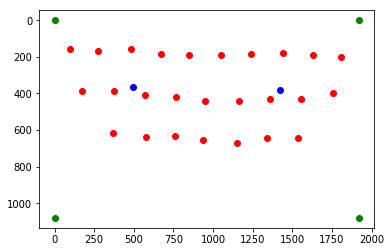

In [3]:
# Divide into left, right and middle sections of keyboard

left_keys = set(list("qwertasdfzxc"))
right_keys = set(list("yuiophjklbnm"))
middle_keys = set(list("gv"))

keyboard_sections = [left_keys, right_keys, middle_keys]

char_section_dict = collections.defaultdict(int)
for char_ascii in range(26):
    char = chr(ord("a") + char_ascii)
    for ind, section in enumerate(keyboard_sections):
        if char in section:
            char_section_dict[char] = ind
            break
print("Characters to sections: {}".format(char_section_dict))

# Initialize left thumb and right thumb positions
left_mean = np.mean(np.array([char_pos_dict[char] for char in left_keys]), axis = 0)
right_mean =  np.mean(np.array([char_pos_dict[char] for char in right_keys]), axis = 0)

thumbs_pos = np.array([left_mean, right_mean])
print("Initial thumb positions: {}". format(thumbs_pos))

for char in char_pos_dict:
    plt.plot(char_pos_dict[char][0], char_pos_dict[char][1], "ro")

for pos_x, pos_y in thumbs_pos:
    plt.plot(pos_x, pos_y, "bo")

plt.plot([0,0,1920,1920],[0,1080,0,1080], "go")    
plt.gca().invert_yaxis()

In [4]:
# Read passages from txt and remove non-alphabetical characters
cleaned_passage = []
with open("pride_and_prejudice.txt", 'r') as f:
    for line in f:
        for char in line:
            if char.isalpha():
                cleaned_passage.append(char.lower())

In [5]:
# Assume first order relations between buttons and type with only one hand
first_order_count = np.array([[0 for i in range(26)] for j in range(26)])

for ind in range(len(cleaned_passage) - 1):
    first_order_count[ord(cleaned_passage[ind]) - ord('a')][ord(cleaned_passage[ind+1]) - ord('a')] += 1

total_dist = 0

for i in range(26):
    for j in range(26):
        pos1, pos2 = char_pos_dict[chr(i + ord('a'))], char_pos_dict[chr(j + ord('a'))]
        total_dist += np.linalg.norm(pos1 - pos2) * first_order_count[i][j]
        
print("Total distance when typing with one hand: {}".format(total_dist))
    

Total distance when typing with one hand: 9006853.584351972


In [6]:
# Assume first order relations and type with two hands, one responsible for each side
prev_char = [None, None]
total_dist = [0, 0]  

Calculated curve_length: 1084.2698247367157
Numerical error: 4.730026177943713e-06
Scaled length:(960.0, 4.18791069129027e-06)


Text(0.5, 1.0, 'Initial keyboard shape after scaling by curve length')

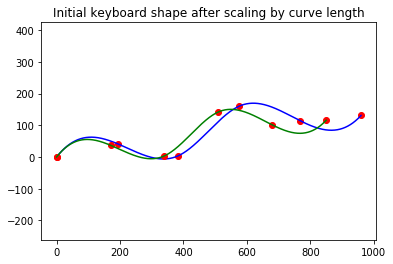

In [126]:
# Decide number of control points to define the curve (probably 1D curve first)
dof = 5
max_height = 200
# Since the keyboard is symmetric, we only need to define half of the keyboard.
inpl_h, inpl_w = 1080*3/4, 1920/2
# Use B-spline to fit the points (to get a smooth surface)
inpl_x = np.array(list(range(0, dof + 1))) / dof * inpl_w
inpl_y = np.random.rand(dof + 1) * max_height
inpl_y[0] = 0

# Interpolate with B-spline
tck = interpolate.splrep(inpl_x, inpl_y, s = 0)
xnew = np.linspace(0, inpl_w, int(inpl_w) * 3)
ynew = interpolate.splev(xnew, tck, der = 0)

plt.plot(inpl_x, inpl_y, 'ro', xnew, ynew, 'b') 
plt.axis('equal')
plt.title("Initial keyboard shape without scaling")
# Find length of spline by numerical integration
# Normalize movement in x direction by curve length to ensure the final lengh
length_integral = lambda x, func: np.sqrt(1 + interpolate.splev(x, func, der = 1) ** 2)
curve_integral = lambda x: length_integral(x, tck)
find_curve_length = lambda x: scipy.integrate.quad(curve_integral,0, x)
total_curve_length, error = find_curve_length(inpl_w)
print("Calculated curve_length: {}".format(total_curve_length))
print("Numerical error: {}".format(error))

scale_factor = inpl_w/total_curve_length
scaled_spline = interpolate.splrep(inpl_x * scale_factor, inpl_y * scale_factor, s = 0)
scaled_xnew = xnew * scale_factor
scaled_ynew = interpolate.splev(scaled_xnew, scaled_spline, der = 0)
scaled_curve_integral  = lambda x: length_integral(x, scaled_spline)
scaled_curve_length = lambda x: scipy.integrate.quad(scaled_curve_integral, 0, x)
print("Scaled length:{}".format(scaled_curve_length(inpl_w * scale_factor)))
plt.plot(inpl_x * scale_factor, inpl_y * scale_factor, 'ro', scaled_xnew, scaled_ynew, 'g-')
plt.axis('equal')
plt.title("Initial keyboard shape after scaling by curve length")

# Option 1. constraint the total length to be 1920 or Option 2 only constrain the coordinates of points
# project points back onto the curve
# for option 1. project onto curve using length
# optimize the height of the points to reduce the movement of the thumbs

In [128]:
# Assume the new keyboard is formed by folding the keyboard onto the curved surface

for key in "qwert":
    flat_x, flat_y = char_pos_dict[key]
    print(flat_x, find_curve_length(20)[0] - flat_x)
    pos_x_on_curved_keyboard = optimize.brentq(lambda x: scaled_curve_length(x)[0] - flat_x, 0, inpl_w)
    
    print("Key: {}\tCurved x: {}".format(key, pos_x_on_curved_keyboard))
    
    



95.36363636363636 -65.11402554220435
Key: q	Curved x: 76.5168763821381
275.2647058823529 -245.0150950609209
Key: w	Curved x: 246.81854328478917
483.875 -453.62538917856796
Key: e	Curved x: 426.8036130087255
671.625 -641.375389178568
Key: r	Curved x: 588.5109500518216
850.2115384615385 -819.9619276401064
Key: t	Curved x: 752.838771857515


In [129]:
def plotMeshShape(x,spline, plot_points = False, points = None):
    y = np.linspace(0, inpl_h,3)
    X, Y = np.meshgrid(x,y)
    Z = interpolate.splev(X, spline, der = 0)
    data = [go.Mesh3d(x = X.flatten(), y= Y.flatten(), z= Z.flatten())]
    layout = go.Layout(
             scene=dict(
                 aspectmode='data'))
    fig = go.Figure(data = data, layout = layout)

    if plot_points:
        fig = go.Figure(data + [go.Scatter3d(x = points[:,0], y = points[:,1], z = points[:,2])], layout = layout)
    
    plotly.offline.iplot(fig)
    
plotMeshShape(scaled_xnew ,scaled_spline, True, np.array([[1200,1,2]]))

In [109]:
scaled_xnew[-1]

843.7228269905586